In [33]:
### Imports and data ###

#Imports
import tensorflow as tf
import keras as k
import keras.backend as Kb
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import numpy as np

import datetime as dt
import matplotlib as style
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler

#Get Data from yahoo

start = dt.datetime(2001,1,1)
end = dt.datetime(2016,12,31)
df = web.DataReader('AAPL', 'yahoo', start, end)[['Close']]

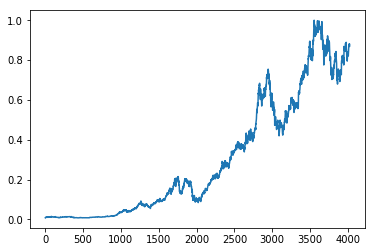

In [34]:
#Format data for use

df = df.values.reshape(len(df), 1)
max_val = np.amax(df)
df = df/max_val

plt.plot(df)
plt.show()

data_split = 0.8
train_data = df[:int(len(df)*data_split)]
test_data = df[int(len(df)*data_split):]

In [35]:
def create_ts(ds, inLen, outLen):
    X, Y = [], []
    totLen = inLen+outLen
    for i in range(len(ds)-totLen-1):
        X.append(ds[i:(i+inLen), 0])
        Y.append(ds[(i+inLen):(i+totLen), 0])
    return np.array(X), np.array(Y)

in_series = 100
out_series = 22

x_train, y_train = create_ts(train_data, in_series, out_series)
x_test, y_test = create_ts(test_data, in_series, out_series)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [36]:
#Create the model

def cust_loss(yTrue,yPred):
    difs = 0.0
    for i in range(21):
        difs += Kb.square(Kb.square(yTrue[i]-yTrue[i+1]))
    difs /= 22
    return Kb.mean(Kb.square(yTrue - yPred) + difs, axis=-1)

def cust_loss2(yTrue,yPred):
    loss = 0.0
    for i in range(21):
        difs = Kb.square(Kb.square(yTrue[i]-yTrue[i+1]))
        dif_pred = (yTrue[i]-yPred[i])**2
        loss += difs + (dif_pred * (i+1)**.5)
    loss /= 21
    loss = loss+yTrue-yTrue
    return loss

model = Sequential()

model.add(LSTM(10, input_shape=(in_series, 1)))
model.add(Dense(out_series))

opt = Adam(lr=0.01, decay=1e-6)
model.compile(loss=cust_loss2, optimizer=opt, metrics=['mse'])

In [37]:
#Fit the model to the training data

model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
3097/3097 [==============================] - 5s 2ms/step - loss: 0.0394 - mean_squared_error: 0.0072
Epoch 2/25
3097/3097 [==============================] - 3s 939us/step - loss: 0.0194 - mean_squared_error: 5.1987e-04
Epoch 3/25
3097/3097 [==============================] - 3s 946us/step - loss: 0.0170 - mean_squared_error: 4.0613e-04
Epoch 4/25
3097/3097 [==============================] - 3s 953us/step - loss: 0.0185 - mean_squared_error: 4.4762e-04
Epoch 5/25
3097/3097 [==============================] - 3s 947us/step - loss: 0.0180 - mean_squared_error: 3.7255e-04
Epoch 6/25
3097/3097 [==============================] - 3s 963us/step - loss: 0.0175 - mean_squared_error: 3.6605e-04
Epoch 7/25
3097/3097 [==============================] - 3s 951us/step - loss: 0.0187 - mean_squared_error: 3.5928e-04
Epoch 8/25
3097/3097 [==============================] - 3s 952us/step - loss: 0.0187 - mean_squared_error: 3.7463e-04
Epoch 9/25
3097/3097 [==============================] - 3s 954

In [38]:
#Attempt to predict the test data

pred = model.predict(x_test)

pred = pred*max_val
test_data = test_data*max_val
y_test = y_test*max_val

print(pred[50]-y_test[50])

[-1.34008026 -2.24594116 -1.33146667 -1.7600174  -2.90328979 -3.94507599
 -4.2370224  -5.42566681 -6.14324188 -5.35108948 -3.72520447 -3.51428223
 -3.86629486 -4.41555786 -4.37058258 -4.35251617 -3.22290802 -3.47632599
 -3.09663391 -2.69042969 -4.6293335  -4.64260864]


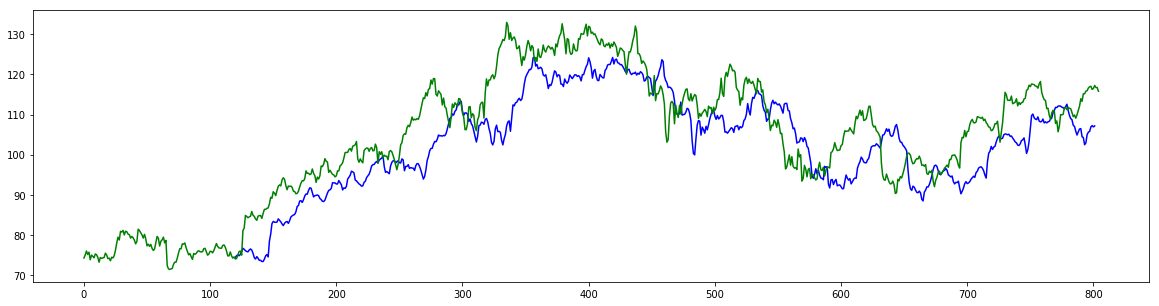

In [47]:
day = 21

plt.figure(figsize=(20,5))

plt.plot(range(99+day, test_data.shape[0]-24+day), pred[:,day], color='blue')
plt.plot(test_data, color='green')
plt.show()

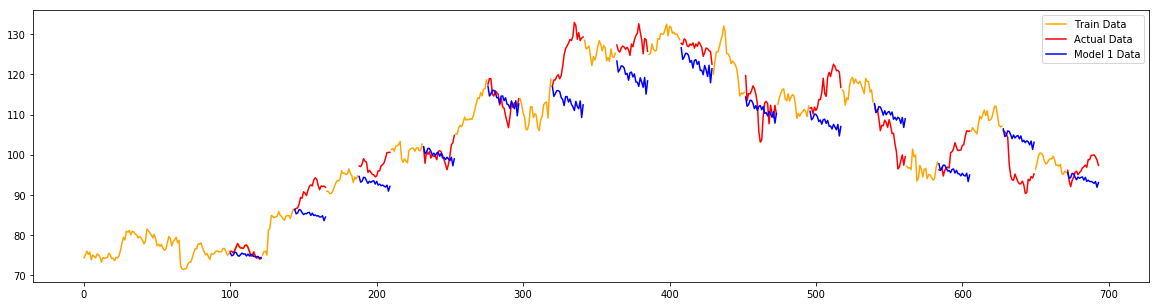

In [46]:
act_vals = 22
pred_vals = 22
tot_vals = act_vals + pred_vals

plt.figure(figsize=(20,5))

plt.plot(range(100+act_vals), test_data[:100+act_vals], color='orange', label='Train Data')
plt.plot(range(100, 100+pred_vals), test_data[100:100+pred_vals], color='red', label='Actual Data')
plt.plot(range(100, 100+pred_vals), pred[0], color='blue', label='Model 1 Data')

for x in range(100+pred_vals, x_test.shape[0]-pred_vals, tot_vals):
    plt.plot(range(x, x+act_vals), test_data[x:x+act_vals], color='orange')
    plt.plot(range(x+act_vals, x+tot_vals), test_data[x+act_vals:x+tot_vals], color='red')
    plt.plot(range(x+act_vals, x+tot_vals), pred[x-100+act_vals], color='blue')
plt.legend()
plt.show()

In [42]:
#Predict training data

pred2 = model.predict(x_train)

pred2 = pred2*max_val
train_data = train_data*max_val
y_train = y_train*max_val

print(pred2[50]-y_train[50])

[-0.37856722 -0.88206238  0.13975763 -0.45230508 -0.22396743 -0.0817399
  0.10389435 -0.35695153 -0.39916909 -0.25367928 -0.43779504  0.16561627
 -0.01663411 -0.30875421 -0.12563181 -0.22864962  0.23478436 -0.07339597
  0.11420882  0.73222113  0.64791429  0.50667989]


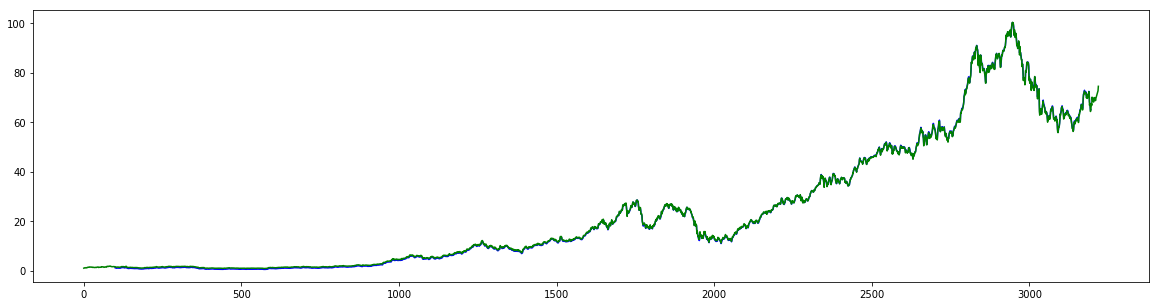

In [43]:
day = 0

plt.figure(figsize=(20,5))

plt.plot(range(99+day, train_data.shape[0]-24+day), pred2[:,day], color='blue')
plt.plot(train_data, color='green')
plt.show()

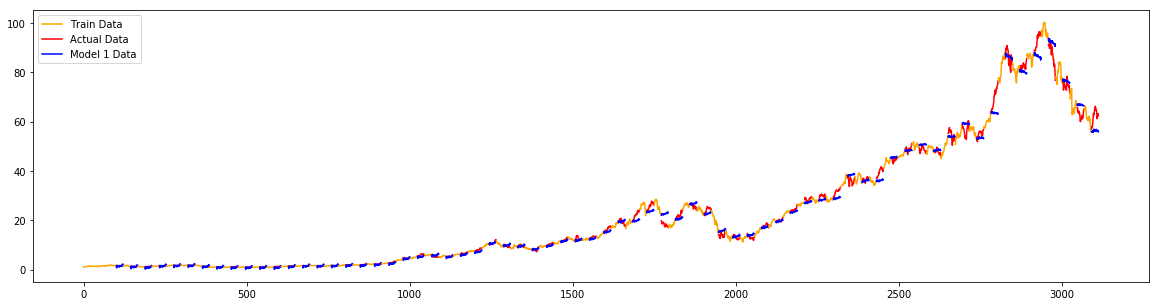

In [44]:
act_vals = 22
pred_vals = 22
tot_vals = act_vals + pred_vals

plt.figure(figsize=(20,5))

plt.plot(range(100+act_vals), train_data[:100+act_vals], color='orange', label='Train Data')
plt.plot(range(100, 100+pred_vals), train_data[100:100+pred_vals], color='red', label='Actual Data')
plt.plot(range(100, 100+pred_vals), pred2[0], color='blue', label='Model 1 Data')

for x in range(100+pred_vals, x_train.shape[0]-pred_vals, tot_vals):
    plt.plot(range(x, x+act_vals), train_data[x:x+act_vals], color='orange')
    plt.plot(range(x+act_vals, x+tot_vals), train_data[x+act_vals:x+tot_vals], color='red')
    plt.plot(range(x+act_vals, x+tot_vals), pred2[x-100+act_vals], color='blue')
plt.legend()
plt.show()